## Maldist Model

Here we are going to follow the Maldist model by dividing the dataset into 4 classes Benign, Dridex, Emotet and Hacintor
But first we need to balanced the data
After that we can train our several models and compare their Accuracy, Precision, Recall and F1-Score
Then we can do a confussion matrix

We are going to balanced the data by subsampling hancitor and oversampling the rest. Our media samples will be 7000

In [1]:
import pandas as pd
import numpy as np

dridex = pd.read_csv("../Datasets/Dridex.csv", sep=",")
emotet = pd.read_csv("../Datasets/Emotet.csv", sep=",")
hancitor = pd.read_csv("../Datasets/Hancitor.csv", sep=",")
valak = pd.read_csv("../Datasets/Valak.csv", sep=",")
benign = pd.read_csv("../Datasets/Benign.csv", sep=",")

print(f"The shape of the dridex dataset is {dridex.shape[0]} samples, {dridex.shape[1]} features")
print(f"The shape of the emotet dataset is {emotet.shape[0]} samples, {emotet.shape[1]} features")
print(f"The shape of the hancitor dataset is {hancitor.shape[0]} samples, {hancitor.shape[1]} features")
print(f"The shape of the valak dataset is {valak.shape[0]} samples, {valak.shape[1]} features")
print(f"The shape of the benign dataset is {benign.shape[0]} samples, {benign.shape[1]} features")

The shape of the dridex dataset is 3138 samples, 201 features
The shape of the emotet dataset is 10362 samples, 201 features
The shape of the hancitor dataset is 12798 samples, 201 features
The shape of the valak dataset is 1303 samples, 201 features
The shape of the benign dataset is 2473 samples, 201 features


In [2]:
data = pd.read_csv("../Datasets/MalDist_Dataset.csv", sep=",")

mal = data[data['label'] == 1].drop(columns=['label'])
legit = data[data['label'] == 0].drop(columns=['label'])

print(f"The shape of the legit dataset is {legit.shape[0]} samples, {legit.shape[1]} features")
print(f"The shape of the mal dataset is {mal.shape[0]} samples, {mal.shape[1]} features")

The shape of the legit dataset is 2473 samples, 200 features
The shape of the mal dataset is 27601 samples, 200 features


In [1]:
!pip install imbalanced-learn

  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import pandas as pd

# Separar características y etiquetas
X = data.drop(columns=['label', 'family', 'file_name'])
y = data['family']

print("Missing values before handling:", X.isna().sum().sum())
print("Infinite values before handling:", np.isinf(X.values).sum())

# Tamaño objetivo de las clases balanceadas
target_class_size = 7000  

# Submuestreo para Hacintor
subsampled_dfs = []
for label in y.unique():
    class_data = data[data['family'] == label]
    if len(class_data) > target_class_size:
        print(f"Submuestreo {label}")
        subsampled_class = resample(class_data, 
                                    replace=False, 
                                    n_samples=target_class_size, 
                                    random_state=42)
        subsampled_dfs.append(subsampled_class)
    else:
        subsampled_dfs.append(class_data)

# Combinar datos submuestreados
balanced_df = pd.concat(subsampled_dfs)

# Sobremuestreo para clases muy pequeñas
X_balanced = balanced_df.drop(columns=['label', 'family', 'file_name'])
y_balanced = balanced_df['family']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_balanced, y_balanced)

# Crear un nuevo DataFrame balanceado
balanced_data = pd.concat([pd.DataFrame(X_resampled, columns=X_balanced.columns), pd.Series(y_resampled, name='family')], axis=1)

print("Clases después de balancear:")
print(balanced_data['family'].value_counts())

# Guardar el dataset balanceado si es necesario
balanced_data.to_csv("../Datasets/Maldist_balanced1.csv", index=False)


Missing values before handling: 0
Infinite values before handling: 0
Submuestreo 3
Submuestreo 2
Clases después de balancear:
3    7000
2    7000
1    7000
0    7000
4    7000
Name: family, dtype: int64


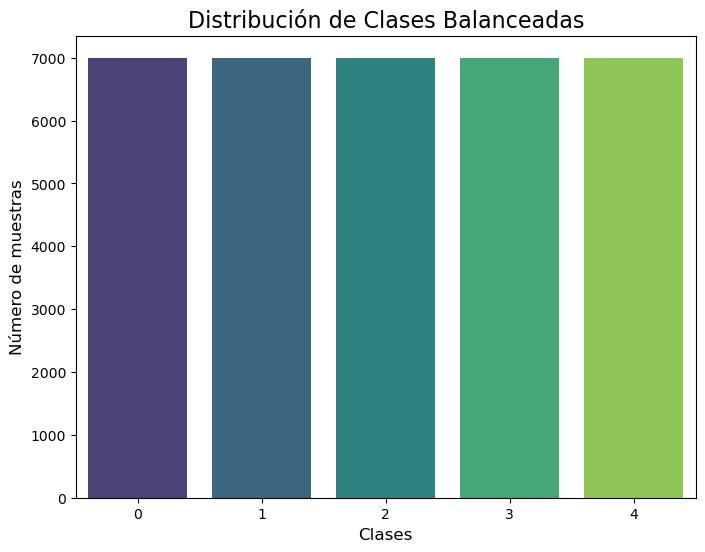

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Barplot para mostrar la distribución de clases
plt.figure(figsize=(8, 6))
sns.countplot(x='family', data=balanced_data, palette='viridis')
plt.title('Distribución de Clases Balanceadas', fontsize=16)
plt.xlabel('Clases', fontsize=12)
plt.ylabel('Número de muestras', fontsize=12)
plt.show()


Models will be:
- Random Forest
- Gradient Boosting
- KNN
- Linear Regression
- Neural Networks
- LSTM


### Random Forest

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

X = balanced_data.drop(columns=['family'])
y = balanced_data['family']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=50)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

In [6]:
print(f"The score of the algorithm: {rf.score(X_test,y_test)*100}")

The score of the algorithm: 99.08571428571429


In [7]:
cm = confusion_matrix(y_test, y_pred_rf)
cm

array([[1404,    0,    1,    5,    0],
       [   1, 1397,    5,    0,    7],
       [   2,   16, 1371,    0,    8],
       [   2,    5,    2, 1394,    2],
       [   0,    6,    2,    0, 1370]])

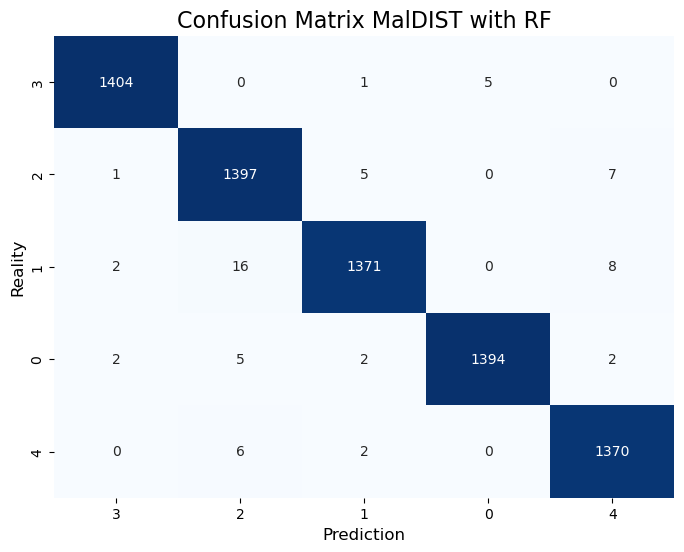

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=balanced_data['family'].unique(), yticklabels=balanced_data['family'].unique(), cbar=False)
plt.title('Confusion Matrix MalDIST with RF', fontsize=16)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Reality', fontsize=12)

plt.savefig('ConfMat_Maldist_Classes.png', bbox_inches='tight', dpi=300)
plt.show()

In [9]:
classification_report(y_test, y_pred_rf)

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      1410\n           1       0.98      0.99      0.98      1410\n           2       0.99      0.98      0.98      1397\n           3       1.00      0.99      0.99      1405\n           4       0.99      1.00      0.99      1378\n\n    accuracy                           0.99      7000\n   macro avg       0.99      0.99      0.99      7000\nweighted avg       0.99      0.99      0.99      7000\n'

In [10]:
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, average='macro')  # Puedes usar 'micro', 'macro', 'weighted' 
recall = recall_score(y_test, y_pred_rf, average='macro')
f1 = f1_score(y_test, y_pred_rf, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9904
Precision: 0.9905
Recall: 0.9904
F1 Score: 0.9904


In [45]:
import joblib  
joblib.dump(rf, "models/MalDist_rf_osss_.pkl")

['models/MalDist_rf_osss_.pkl']

### Extratree classifier

In [11]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

extratrees = ExtraTreesClassifier().fit(X, y)
select = SelectFromModel(extratrees, prefit=True)
data_in_new = select.transform(X)

print(X.shape, data_in_new.shape)

(35000, 198) (35000, 60)


/home/fingopolo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [12]:
features = data_in_new.shape[1]
importances = extratrees.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(features):
    print(f"{f+1}, {data.columns[2+indices[f]]}, {importances[indices[f]]}")

1, packet_1_iat, 0.06114152525204732
2, packet_9_iat, 0.03724215502699316
3, packet_4_tcp_window, 0.025730042185650222
4, packet_7_iat, 0.024895083712457345
5, packet_8_iat, 0.024679518731259086
6, packet_12_iat, 0.023219483017331666
7, packet_3_iat, 0.02306116428195004
8, packet_13_iat, 0.022823822081952893
9, packet_4_iat, 0.021859719275753708
10, bidirectional_tot_size, 0.021778499738015406
11, packet_1_tcp_window, 0.020061932714212544
12, packet_6_iat, 0.01793427696756272
13, handshake_mean_size, 0.016033825603217262
14, packet_2_iat, 0.015619277205909488
15, datatransfer_tot_size, 0.014734880598208957
16, packet_6_direction, 0.014662471789046106
17, packet_11_iat, 0.014256362653802092
18, packet_4_direction, 0.013520108356688392
19, src2dst_tot_size, 0.013011469921156416
20, handshake_max_size, 0.012002610891218568
21, packet_16_iat, 0.011653728957642093
22, datatransfer_std_size, 0.010929964412491961
23, dst2src_mean_size, 0.010673669788558106
24, dst2src_min_size, 0.010559407541

In [13]:
X_train_extree, X_test_extree, y_train_extree, y_test_extree = train_test_split(data_in_new, y, test_size=0.2, random_state=42)
rf_extree = RandomForestClassifier(n_estimators=50)

rf_extree.fit(X_train_extree, y_train_extree)

y_pred_extree = rf_extree.predict(X_test_extree)

In [14]:
print(f"The score of the algorithm: {rf_extree.score(X_test_extree,y_test_extree)*100}")

The score of the algorithm: 98.95714285714286


In [15]:
cm = confusion_matrix(y_test_extree, y_pred_extree)
cm

array([[1403,    0,    2,    5,    0],
       [   0, 1391,    9,    0,   10],
       [   0,   16, 1374,    0,    7],
       [   2,    6,    1, 1394,    2],
       [   0,   11,    2,    0, 1365]])

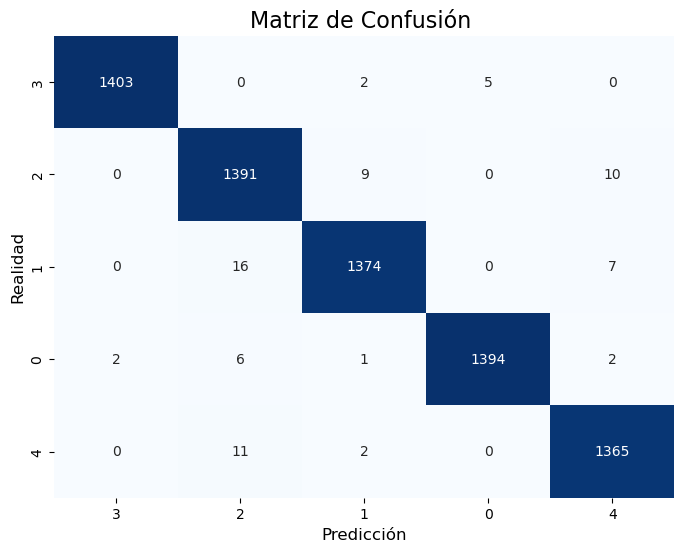

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=balanced_data['family'].unique(), yticklabels=balanced_data['family'].unique(), cbar=False)
plt.title('Confusion Matrix MalDIST with RF', fontsize=16)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Reality', fontsize=12)

plt.savefig('ConfMat_Maldist_Classes.png', bbox_inches='tight', dpi=300)
plt.show()

In [17]:
classification_report(y_test_extree, y_pred_extree)

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      1410\n           1       0.98      0.99      0.98      1410\n           2       0.99      0.98      0.99      1397\n           3       1.00      0.99      0.99      1405\n           4       0.99      0.99      0.99      1378\n\n    accuracy                           0.99      7000\n   macro avg       0.99      0.99      0.99      7000\nweighted avg       0.99      0.99      0.99      7000\n'

In [18]:
accuracy = accuracy_score(y_test_extree, y_pred_extree)
precision = precision_score(y_test_extree, y_pred_extree, average='macro')  # Puedes usar 'micro', 'macro', 'weighted' 
recall = recall_score(y_test_extree, y_pred_extree, average='macro')
f1 = f1_score(y_test_extree, y_pred_extree, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9896
Precision: 0.9896
Recall: 0.9896
F1 Score: 0.9896


In [56]:
joblib.dump(rf_extree, "models/MalDist_extree_osss_.pkl")

['models/MalDist_extree_osss_.pkl']

### Gradient Boosting (XGBoost)

In [20]:
!pip install xgboost

  Using cached xgboost-2.1.4-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.4-py3-none-manylinux_2_28_x86_64.whl (223.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 34.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [21]:
from xgboost import XGBClassifier

# Crear y entrenar el modelo de Gradient Boosting
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(X_train, y_train)

# Predecir y evaluar
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Classifier")
print(classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")

XGBoost Classifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1410
           1       0.98      0.99      0.98      1410
           2       0.99      0.98      0.99      1397
           3       1.00      0.99      1.00      1405
           4       0.99      0.99      0.99      1378

    accuracy                           0.99      7000
   macro avg       0.99      0.99      0.99      7000
weighted avg       0.99      0.99      0.99      7000

Accuracy: 0.9904


In [22]:
print(f"The score of the algorithm: {xgb.score(X_test,y_test)*100}")

The score of the algorithm: 99.04285714285714


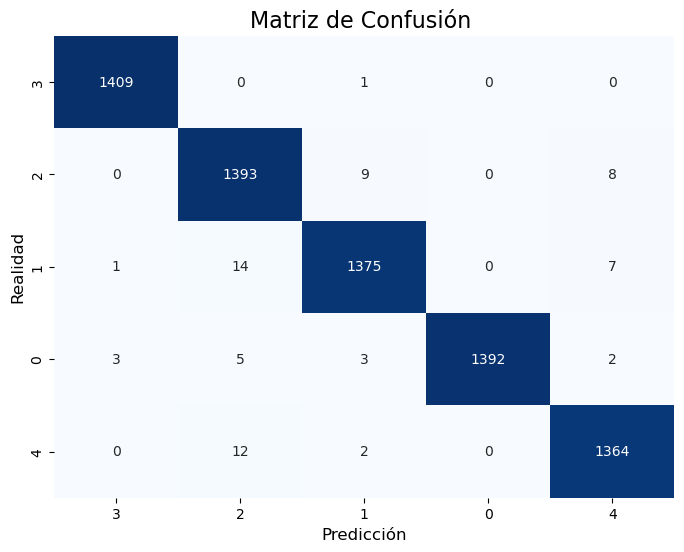

In [24]:
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=balanced_data['family'].unique(), yticklabels=balanced_data['family'].unique(), cbar=False)
plt.title('Matriz de Confusión ', fontsize=16)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Realidad', fontsize=12)
plt.show()

In [25]:
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb, average='macro')  # Puedes usar 'micro', 'macro', 'weighted' 
recall = recall_score(y_test, y_pred_xgb, average='macro')
f1 = f1_score(y_test, y_pred_xgb, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9904
Precision: 0.9905
Recall: 0.9904
F1 Score: 0.9904


In [32]:
joblib.dump(xgb, "models/MalDist_xgb_osss_.pkl")

['models/MalDist_xgb_osss_.pkl']

### KNN

In [26]:
from sklearn.neighbors import KNeighborsClassifier

# Crear y entrenar el modelo KNN
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

# Predecir y evaluar
y_pred_knn = knn.predict(X_test)

print("K-Nearest Neighbors")
print(classification_report(y_test, y_pred_knn))
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")

K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1410
           1       0.93      0.94      0.94      1410
           2       0.95      0.94      0.94      1397
           3       0.99      0.99      0.99      1405
           4       0.95      0.94      0.95      1378

    accuracy                           0.96      7000
   macro avg       0.96      0.96      0.96      7000
weighted avg       0.96      0.96      0.96      7000

Accuracy: 0.9606


In [27]:
print(f"The score of the algorithm: {knn.score(X_test,y_test)*100}")

The score of the algorithm: 96.05714285714285


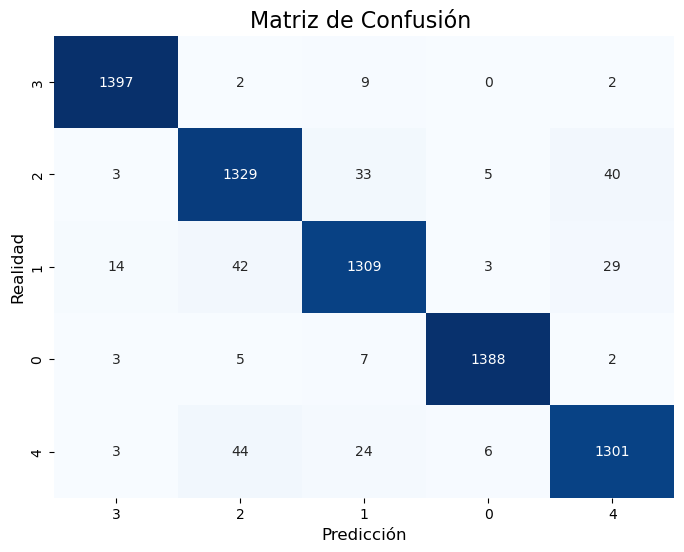

In [28]:
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=balanced_data['family'].unique(), yticklabels=balanced_data['family'].unique(), cbar=False)
plt.title('Matriz de Confusión ', fontsize=16)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Realidad', fontsize=12)
plt.show()

In [29]:
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn, average='macro')  # Puedes usar 'micro', 'macro', 'weighted' 
recall = recall_score(y_test, y_pred_knn, average='macro')
f1 = f1_score(y_test, y_pred_knn, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9606
Precision: 0.9605
Recall: 0.9605
F1 Score: 0.9605


In [61]:
joblib.dump(knn, "models/MalDist_knn_osss_.pkl")

['models/MalDist_knn_osss_.pkl']

### Logistic Regresion

In [30]:
from sklearn.linear_model import LogisticRegression

# Crear y entrenar el modelo de Regresión Lineal
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predecir y evaluar
y_pred_log_reg = log_reg.predict(X_test)

print("Logistic Regression")
print(classification_report(y_test, y_pred_log_reg))
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")

Logistic Regression
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1410
           1       0.83      0.83      0.83      1410
           2       0.75      0.78      0.76      1397
           3       0.94      0.98      0.96      1405
           4       0.72      0.72      0.72      1378

    accuracy                           0.83      7000
   macro avg       0.83      0.83      0.83      7000
weighted avg       0.83      0.83      0.83      7000

Accuracy: 0.8274


/home/fingopolo/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
print(f"The score of the algorithm: {log_reg.score(X_test,y_test)*100}")

The score of the algorithm: 82.74285714285713


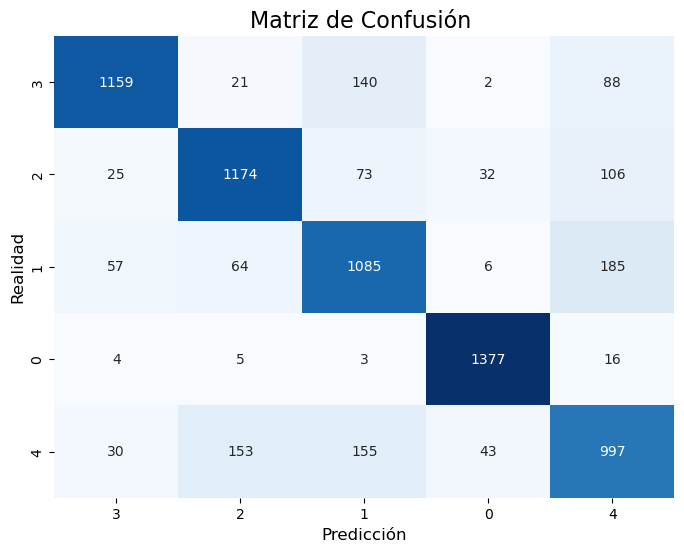

In [32]:
cm = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=balanced_data['family'].unique(), yticklabels=balanced_data['family'].unique(), cbar=False)
plt.title('Matriz de Confusión ', fontsize=16)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Realidad', fontsize=12)
plt.show()

In [33]:
accuracy = accuracy_score(y_test, y_pred_log_reg)
precision = precision_score(y_test, y_pred_log_reg, average='macro')  # Puedes usar 'micro', 'macro', 'weighted' 
recall = recall_score(y_test, y_pred_log_reg, average='macro')
f1 = f1_score(y_test, y_pred_log_reg, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8274
Precision: 0.8284
Recall: 0.8270
F1 Score: 0.8271


In [62]:
joblib.dump(log_reg, "models/MalDist_logreg_osss_.pkl")

['models/MalDist_logreg_osss_.pkl']

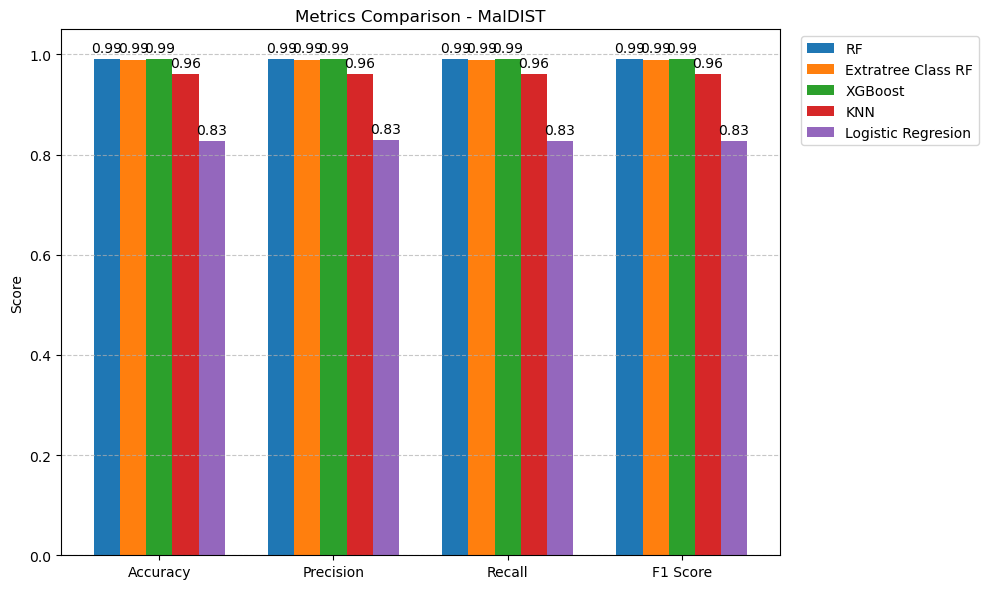

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Métricas (eje X)
metricas = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Modelos
modelos = ['RF', 'Extratree Class RF', 'XGBoost', 'KNN', 'Logistic Regresion']

# Valores por modelo en orden [Accuracy, Precision, Recall, F1 Score]
rf = [0.9904, 0.9905, 0.9904, 0.9904]
extratree = [0.9896, 0.9896, 0.9896, 0.9896]
xgb = [0.9904, 0.9905, 0.9904, 0.9904]
knn = [0.9606, 0.9605, 0.9605, 0.9605]
logreg = [0.8274, 0.8284, 0.8270, 0.8271]

# Agrupar en una lista
valores = [rf, extratree, xgb, knn, logreg]

# Posiciones del eje X
x = np.arange(len(metricas))
width = 0.15  # Ancho de barra

# Crear figura
fig, ax = plt.subplots(figsize=(10, 6))

# Dibujar barras por modelo
for i, modelo in enumerate(modelos):
    rects = ax.bar(x + (i - 2) * width, valores[i], width, label=modelo)
    # Etiquetas encima de las barras
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Personalizar gráfico
ax.set_ylabel('Score')
ax.set_title('Metrics Comparison - MalDIST')
ax.set_xticks(x)
ax.set_xticklabels(metricas)
ax.set_ylim(0, 1.05)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Leyenda en esquina superior derecha fuera del gráfico
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
# Guardar como imagen
plt.savefig('comparacion_modelos_maldist.png', bbox_inches='tight', dpi=300)

plt.show()